In [1]:
!pip install pandas plotly prophet openpyxl


In [2]:
!pip install pandas plotly prophet


In [3]:
import pandas as pd

# Load the dataset
data = pd.read_csv('covid_19_clean_complete.csv')

# Preview the dataset
print(data.head())
print(data.info())


  Province/State Country/Region       Lat       Long        Date  Confirmed  \
0            NaN    Afghanistan  33.93911  67.709953  2020-01-22          0   
1            NaN        Albania  41.15330  20.168300  2020-01-22          0   
2            NaN        Algeria  28.03390   1.659600  2020-01-22          0   
3            NaN        Andorra  42.50630   1.521800  2020-01-22          0   
4            NaN         Angola -11.20270  17.873900  2020-01-22          0   

   Deaths  Recovered  Active             WHO Region  
0       0          0       0  Eastern Mediterranean  
1       0          0       0                 Europe  
2       0          0       0                 Africa  
3       0          0       0                 Europe  
4       0          0       0                 Africa  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0

In [4]:
# Fill missing values with 0
data.fillna(0, inplace=True)


In [5]:
# Ensure 'Date' is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Verify changes
print(data.dtypes)


Province/State            object
Country/Region            object
Lat                      float64
Long                     float64
Date              datetime64[ns]
Confirmed                  int64
Deaths                     int64
Recovered                  int64
Active                     int64
WHO Region                object
dtype: object


In [6]:
# Aggregate data
global_trends = data.groupby('Date')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Preview
print(global_trends.head())


        Date  Confirmed  Deaths  Recovered
0 2020-01-22        555      17         28
1 2020-01-23        654      18         30
2 2020-01-24        941      26         36
3 2020-01-25       1434      42         39
4 2020-01-26       2118      56         52


In [7]:
import plotly.express as px

# Line plot for global trends
fig = px.line(global_trends, x='Date', y=['Confirmed', 'Deaths', 'Recovered'],
              title='Global COVID-19 Trends', labels={'value': 'Count', 'variable': 'Category'})
fig.show()


In [8]:
# Aggregate data by country
country_trends = data.groupby('Country/Region')[['Confirmed', 'Deaths', 'Recovered']].max().reset_index()

# Bar chart for top affected countries
fig = px.bar(country_trends.sort_values(by='Confirmed', ascending=False).head(10),
             x='Country/Region', y='Confirmed', title='Top 10 Affected Countries')
fig.show()


In [9]:
# Latest data for mapping
latest_data = data[data['Date'] == data['Date'].max()]

# World map visualization
fig = px.choropleth(latest_data, locations='Country/Region', locationmode='country names',
                    color='Confirmed', title='Global COVID-19 Confirmed Cases (Latest)')
fig.show()


In [10]:
from prophet import Prophet

# Prepare data for Prophet
forecast_data = global_trends[['Date', 'Confirmed']].rename(columns={'Date': 'ds', 'Confirmed': 'y'})

# Initialize and fit the model
model = Prophet()
model.fit(forecast_data)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph06v23si/2l_iur80.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph06v23si/u3zbomat.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95911', 'data', 'file=/tmp/tmph06v23si/2l_iur80.json', 'init=/tmp/tmph06v23si/u3zbomat.json', 'output', 'file=/tmp/tmph06v23si/prophet_modelgxdywn2y/prophet_model-20241220055620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:56:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:56:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


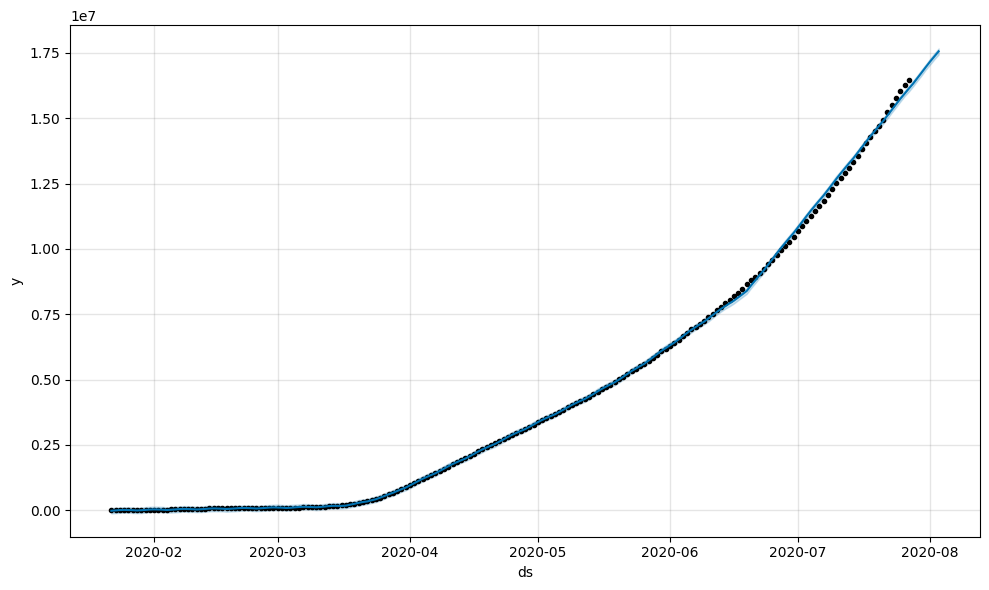

In [11]:
# Create a future dataframe
future = model.make_future_dataframe(periods=7)

# Make predictions
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
fig.show()


In [12]:
import plotly.graph_objects as go

# Combine actual and predicted data
fig = go.Figure()
fig.add_trace(go.Scatter(x=forecast_data['ds'], y=forecast_data['y'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Predicted'))
fig.update_layout(title='COVID-19 Confirmed Cases Forecast', xaxis_title='Date', yaxis_title='Cases')
fig.show()


In [13]:
# Add recovery and mortality rates
global_trends['Recovery_Rate'] = (global_trends['Recovered'] / global_trends['Confirmed']) * 100
global_trends['Mortality_Rate'] = (global_trends['Deaths'] / global_trends['Confirmed']) * 100

# Line plot for rates
fig = px.line(global_trends, x='Date', y=['Recovery_Rate', 'Mortality_Rate'],
              title='Recovery and Mortality Rates Over Time', labels={'value': 'Rate (%)', 'variable': 'Metric'})
fig.show()


In [14]:
# Select top 5 countries with the highest confirmed cases
top_countries = country_trends.sort_values(by='Confirmed', ascending=False).head(5)['Country/Region']

# Filter data for these countries
top_countries_data = data[data['Country/Region'].isin(top_countries)]

# Line plot for trends in top 5 countries
fig = px.line(top_countries_data, x='Date', y='Confirmed', color='Country/Region',
              title='Trends of Confirmed Cases in Top 5 Affected Countries')
fig.show()


In [15]:
# Map countries to continents (you can use an external library or dictionary)
continent_map = {
    'US': 'North America',
    'India': 'Asia',
    'Brazil': 'South America',
    # Add more mappings as required
}

data['Continent'] = data['Country/Region'].map(continent_map)

# Aggregate by continent
continent_trends = data.groupby(['Continent', 'Date'])[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

# Visualize continent-wise trends
fig = px.line(continent_trends, x='Date', y='Confirmed', color='Continent',
              title='COVID-19 Trends by Continent')
fig.show()


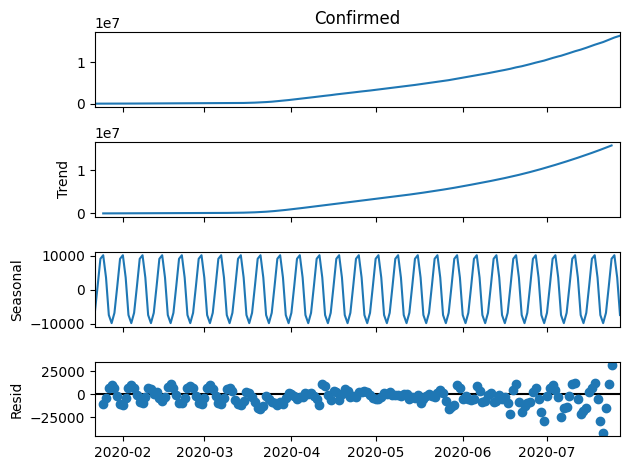

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'global_trends' is already created and contains the 'Date' and 'Confirmed' columns

# Ensure the 'Date' column is in datetime format and set as the index
global_trends['Date'] = pd.to_datetime(global_trends['Date'])
global_trends.set_index('Date', inplace=True)

# Perform decomposition on the 'Confirmed' column
decompose_result = seasonal_decompose(global_trends['Confirmed'], model='additive', period=7)

# Plot the decomposition
decompose_result.plot()
plt.show()


In [19]:
import plotly.express as px

# Reset the index to ensure 'Date' is available as a column
global_trends.reset_index(inplace=True)

# Plot the doubling rate
fig = px.line(global_trends, x='Date', y='Doubling_Rate', title='COVID-19 Infection Doubling Rate')
fig.show()


In [20]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Prepare data
X = global_trends['Date'].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
y = global_trends['Confirmed']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVR model
svr = SVR(kernel='rbf')
svr.fit(X_train_scaled, y_train)

# Predict and plot
y_pred = svr.predict(X_test_scaled)

fig = px.scatter(x=X_test.ravel(), y=y_test, labels={'x': 'Date', 'y': 'Confirmed'},
                 title='SVR Prediction vs Actual')
fig.add_scatter(x=X_test.ravel(), y=y_pred, mode='lines', name='Prediction')
fig.show()


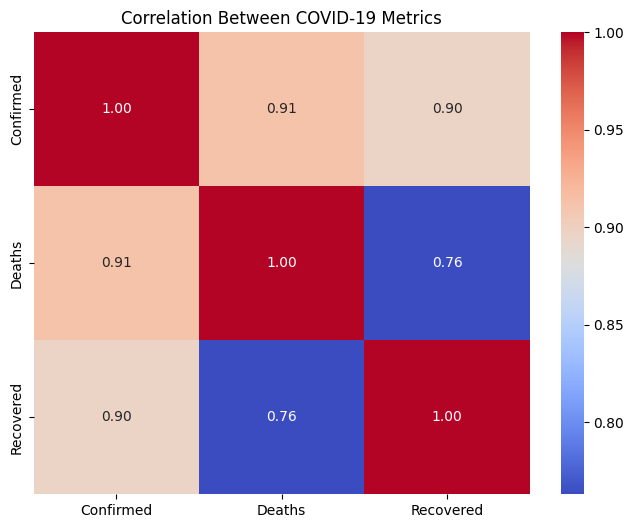

In [21]:
# Calculate correlation
correlation = data[['Confirmed', 'Deaths', 'Recovered']].corr()

# Visualize correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between COVID-19 Metrics')
plt.show()


In [24]:
!pip install streamlit


import streamlit as st
import plotly.express as px

st.title("COVID-19 Analysis and Trends")
st.plotly_chart(fig)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.2 MB/s eta 0:00:00


2024-12-20 06:01:02.437 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-20 06:01:02.831 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-12-20 06:01:02.835 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-20 06:01:02.840 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-20 06:01:02.842 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-20 06:01:02.846 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-20 06:01:02.848 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

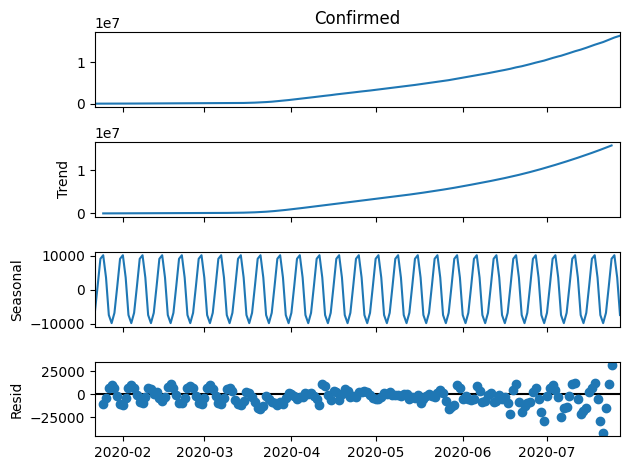

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'global_trends' is already created and contains the 'Date' and 'Confirmed' columns

# Ensure the 'Date' column is in datetime format and set as the index
global_trends['Date'] = pd.to_datetime(global_trends['Date'])
global_trends.set_index('Date', inplace=True)

# Perform decomposition on the 'Confirmed' column
decompose_result = seasonal_decompose(global_trends['Confirmed'], model='additive', period=7)

# Plot the decomposition
decompose_result.plot()
plt.show()
